In [ ]:


!pip install langchain==0.3.26 langchain-community==0.3.27 langchain-text-splitters==0.3.8 pypdf==5.8.0 faiss-cpu langchain-openai chromadb tiktoken transformers accelerate bitsandbytes rank_bm25 sacrebleu rouge-score sentence-transformers


# Simple RAG *basics*

## Індексація Ingestion (завантаження та індексація даних) - приклад коду

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

In [ ]:
# Завантаження PDF
loader = PyPDFLoader("ilmenau.pdf")
docs = loader.load()  # повертає список Document

# Очищення: виділення тексту з "page_content" + базове препроцесування
cleaned_docs = []
for doc in docs:
    text = doc.page_content.replace("\n", " ").strip()
    cleaned_docs.append(Document(page_content=text, metadata=doc.metadata))
print(f"Загалом документів: {len(cleaned_docs)}")


Загалом документів: 2


In [ ]:
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", "."],
    chunk_size=100,
    chunk_overlap=10,
)
chunks = splitter.split_documents(cleaned_docs)
print(f"Загалом чанків: {len(chunks)}")
print(f"Chunk:{chunks[0]}")

Загалом чанків: 19
Chunk:page_content='Опис  міста  Ільменау   Ільменау  —  місто  в  Тюрингії ,  Німеччина,  розташоване  приблизно  за' metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': 'PyPDF', 'creationdate': '', 'title': 'ilmenau', 'source': 'ilmenau.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}


Альтернативи:

    MarkdownHeaderTextSplitter — для структурованих документів

    NLTKTextSplitter, SpacyTextSplitter — синтаксичні

    TokenTextSplitter — по токенах (важливо для OpenAI)

    HTMLHeaderTextSplitter — для HTML

**Документація по кожному спліттеру https://python.langchain.com/api_reference/text_splitters/index.html**

| Задача                        | chunk\_size | chunk\_overlap |
| ----------------------------- | ----------- | -------------- |
| RAG на коротких документах    | 300–500     | 50–100         |
| Технічна документація, закони | 500–800     | 100–200        |
| Книжки, PDF                   | 1000–1500   | 150–300        |



**Документація Langchain https://python.langchain.com/api_reference/langchain/retrievers/langchain.retrievers.document_compressors.base.DocumentCompressorPipeline.html**


In [ ]:
# Отримуємо тексти всіх чанків
texts = [chunk.page_content for chunk in chunks]

# Ініціалізуємо модель ембеддінгів (контекстна трансформерна модель)
from langchain.embeddings import HuggingFaceEmbeddings
emb_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Отримуємо ембедінги для кожного тексту (chunk) — один вектор на chunk
embeddings = emb_model.embed_documents(texts)

# Виводимо кількість отриманих ембедингів (тобто кількість чанків)
print(f"Загалом ембеддінгів (chunk): {len(embeddings)}")

# Перевіряємо тип і розмірність першого ембеддінга
print(f"Тип одного ембеддінга: {type(embeddings[0])}")   # має бути <class 'list'>
print(f"Розмірність ембеддінга: {len(embeddings[0])}")   # зазвичай 384 або 768 — це embedding_dim

# Друкуємо перші кілька значень вектора (просто щоб побачити)
print(f"Фрагмент ембеддінга[0]: {embeddings[0][:5]}")

# Перетворимо все на масив і подивимось загальну форму
import numpy as np
emb_arr = np.array(embeddings)

# emb_arr.shape => (кількість чанків, розмірність одного вектора)
print(f"Форма масиву ембеддингів: {emb_arr.shape}")


Загалом ембеддінгів (chunk'ів): 19
Тип одного ембеддінга: <class 'list'>
Розмірність ембеддінга: 384
Фрагмент ембеддінга[0]: [-0.024306071922183037, 0.03362065181136131, -0.03462771326303482, -0.030139103531837463, -0.018424630165100098]
Форма масиву ембеддингів: (19, 384)


In [ ]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_texts(texts=texts, embedding=emb_model)
print(vectorstore)

In [ ]:
query = "Обід їжа "
docs = vectorstore.similarity_search(query, k=10)

for i, d in enumerate(docs):
    print(f"Result {i+1}:\n{d.page_content[:300]}\n")

Result 1:
insuedthueringen.de+2Mapcarta+2Wikipedia+2   ●  Знаходиться  неподалік  бібліотеки  Curie.     3.

Result 2:
3.  Кафе  в  центрі

Result 3:
Опис  міста  Ільменау   Ільменау  —  місто  в  Тюрингії ,  Німеччина,  розташоване  приблизно  за

Result 4:
краю   Тюринзького   лісу,   висота   —   близько   500 м   над   рівнем   моря   .      Основні

Result 5:
кампусі) insuedthueringen.de+3Mapcarta+3Google  Play+3.      ☕  Заклади  харчування   1.

Result 6:
за  33 км  на  південь   від   Ерфурта   в   долині   річки   Ільм   на   північному   краю

Result 7:
вулиця,  де  розташована  Cafeteria  im  Röntgenbau  (кафетерій  на  кампусі)

Result 8:
Основні  вулиці  та  площі   ●  Straße  des  Friedens  —  частина  пішохідної  зони,  де

Result 9:
●  Години  роботи:     –   Пн–Чт:   08:00–20:00     –   Пт:   08:00–19:30   –  Сб:  11:30–14:00

Result 10:
де  розташовані  невеликі  кафе Wikipedia.   ●  Marktstraße  —  центральна  вулиця  старого



## Теорія: Як дані потрапляють у Векторні БД

Уявіть що  ви маєте  100,000 векторів. Якщо просто порівнювати їх з кожним — це повільно

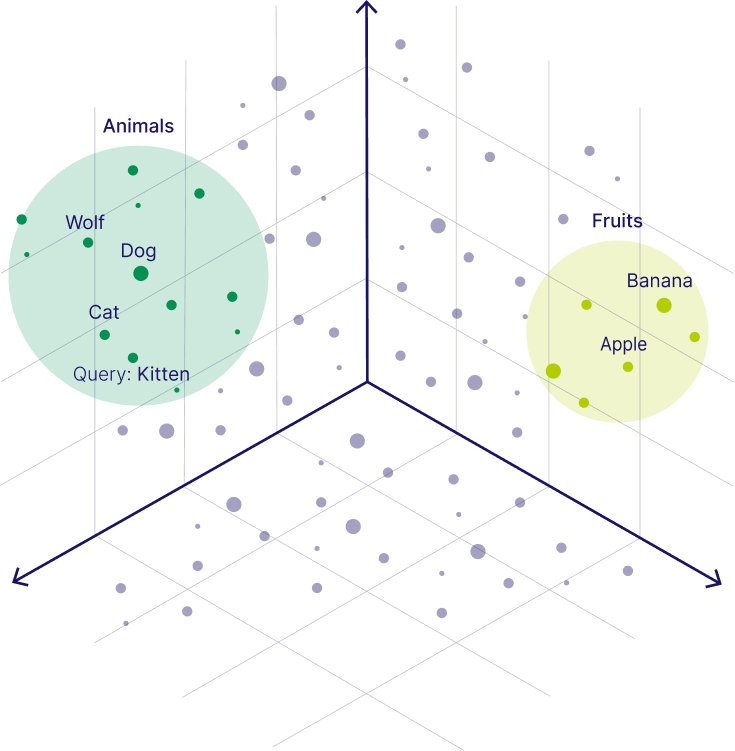


| Компонент                              | Що це таке простими словами                               | Навіщо використовується               |
| -------------------------------------- | --------------------------------------------------------- | ------------------------------------- |
| **K‑Means, Clustering**                | Групування схожих векторів у "кластер"                    | Щоб обмежити область пошуку           |
| **PCA, OPQ, SVD**                      | Зменшення розмірності (compression)                       | Швидкість і менше памʼяті             |
| **HNSW (графи)**                       | Побудова графа зі схожих векторів (як дороги між точками) | Швидкий доступ до "сусідів"           |
| **LSH (Locality Sensitive Hashing)**   | Метод, який кладе схожі вектори в одне "відро"            | Для миттєвого відсіву нерелевантних   |
| **ANN (Approximate Nearest Neighbor)** | Пошук приблизно схожих точок                              | Значно пришвидшує порівняння (vs kNN) |


**Детальніше тут:**

 https://medium.com/@myscale/understanding-vector-indexing-a-comprehensive-guide-d1abe36ccd3c

 https://gagan-mehta.medium.com/understanding-vector-dbs-indexing-algorithms-ce187dca69c2

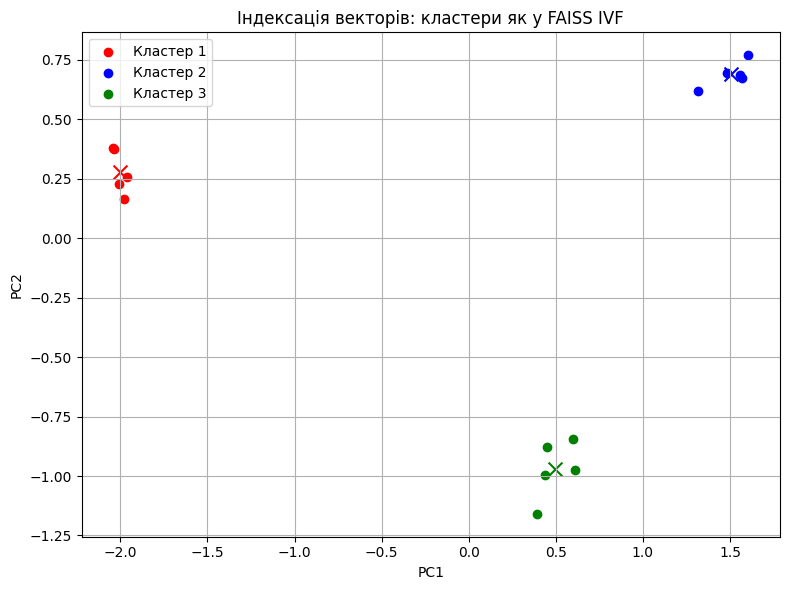

In [ ]:
# Перезапуск середовища - потрібно повторно імпортувати бібліотеки та виконати код
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Симуляція 15 ембеддингів (3 кластери по 5 штук)
np.random.seed(42)
cluster_centers = np.array([[1, 1, 1], [-1, -1, -1], [1, -1, 1]])
embeddings = np.vstack([
    center + 0.1 * np.random.randn(5, 3) for center in cluster_centers
])
labels = np.repeat([0, 1, 2], 5)

# Зменшення до 2D для візуалізації
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Побудова кластерів (імітація індексації, як у FAISS IVF)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_ids = kmeans.fit_predict(embeddings)

# Візуалізація
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i in range(3):
    idx = cluster_ids == i
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f"Кластер {i+1}", color=colors[i])
    center_2d = pca.transform(kmeans.cluster_centers_)[i]
    plt.scatter(center_2d[0], center_2d[1], marker='x', s=100, color=colors[i])

plt.title("Індексація векторів: кластери як у FAISS IVF")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Коли ембеддинги потрапляють у FAISS, база будує кластеризацію простору.

Під час запиту база визначає: "У який кластер потрапляє запит?" → і порівнює лише з точками в цьому кластері.

Це дозволяє шукати в сотні разів швидше, ніж при повному переборі (brute-force).

| Векторна БД  | Що під капотом                            | Переваги                            | Коли використовувати                  |
| ------------ | ----------------------------------------- | ----------------------------------- | ------------------------------------- |
| **FAISS**    | IVF (кластеризація), PQ (стиснення), HNSW | Швидкий, кастомний, GPU-friendly    | Локальні, ресерч проєкти, контроль    |
| **ChromaDB** | Flat (brute-force), або FAISS fallback    | Простий, легко інтегрується         | Невеликі набори даних, навчання       |
| **Pinecone** | Proprietary HNSW + vector sharding        | Хмарний, масштабований, fast        | Production, багато документів         |
| **Weaviate** | HNSW (за замовчуванням), Graph-based      | Добре масштабується, гнучкий        | Якщо треба semantic + metadata search |
| **Milvus**   | IVF, HNSW, GPU-індекси                    | Масштаб, production, швидкість      | Важкі навантаження, багато запитів    |
| **Qdrant**   | HNSW                                      | Рівновага між простотою й масштабом | Якщо потрібен on-prem + fast ANN      |


Крім схожості за embedding, ми можемо фільтрувати документи за атрибутами, які зберігаються в метаданих (наприклад, user_id, source, language, timestamp).

In [ ]:
# ====== ПРИКЛАД КОДУ НЕ РАНИТИ =======
from pinecone import Pinecone

pc = Pinecone(api_key="{{YOUR_API_KEY}}")

if not pc.has_index("my-index"):
    pc.create_index_for_model(
        name="my-index",
        cloud="aws",
        region="us-east-1",
        embed={"model": "openai-text-embedding", "field_map": {"text": "chunk"}}
    )

# Вставка документа з метаданими
pc.Index("my-index").upsert([
    {
        "id": "doc1",
        "values": [0.1, 0.2, ...],  # embedding
        "metadata": {"user_id": "abc123", "language": "uk"}
    }
])

# Запит з фільтром
results = pc.Index("my-index").query(
    vector=[...],
    filter={"user_id": "abc123"},
    top_k=3
)
# ======================
from chromadb import Client
from chromadb.config import Settings

chroma = Client(Settings())

collection = chroma.create_collection(name="my_docs")

# Додавання документів з метаданими
collection.add(
    documents=["Це мій текст", "Інший документ"],
    metadatas=[{"user_id": "abc123"}, {"user_id": "xyz999"}],
    ids=["doc1", "doc2"]
)

# Запит з фільтром
results = collection.query(
    query_texts=["Де поїсти?"],
    n_results=2,
    where={"user_id": "abc123"}
)


## Теорія: Як працює Similarity Search у VectorDB

In [ ]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
# Повторно імпортуємо і демонструємо частину з retrieval та similarity score
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Приклади речень (схожі та несхожі)
sentences = [
    "Я люблю їсти піцу в Італії.",
    "Де можна смачно повечеряти?",
    "Завтра буде дощ і вітер.",
    "Найкращі ресторани знаходяться в центрі міста.",
    "Сьогодні чудова погода для прогулянки.",
    "Де поїсти смачно та недорого?"
]

embeddings = model.encode(sentences, normalize_embeddings=True)


# Вхідний запит
query = "Де поїсти в Італії"
query_embedding = model.encode([query], normalize_embeddings=True)

# Обчислення схожості між запитом і всіма реченнями
similarities = cosine_similarity(query_embedding, embeddings)[0]
print(similarities)

[0.8723693  0.59620357 0.6983887  0.7409996  0.6589824  0.7418015 ]


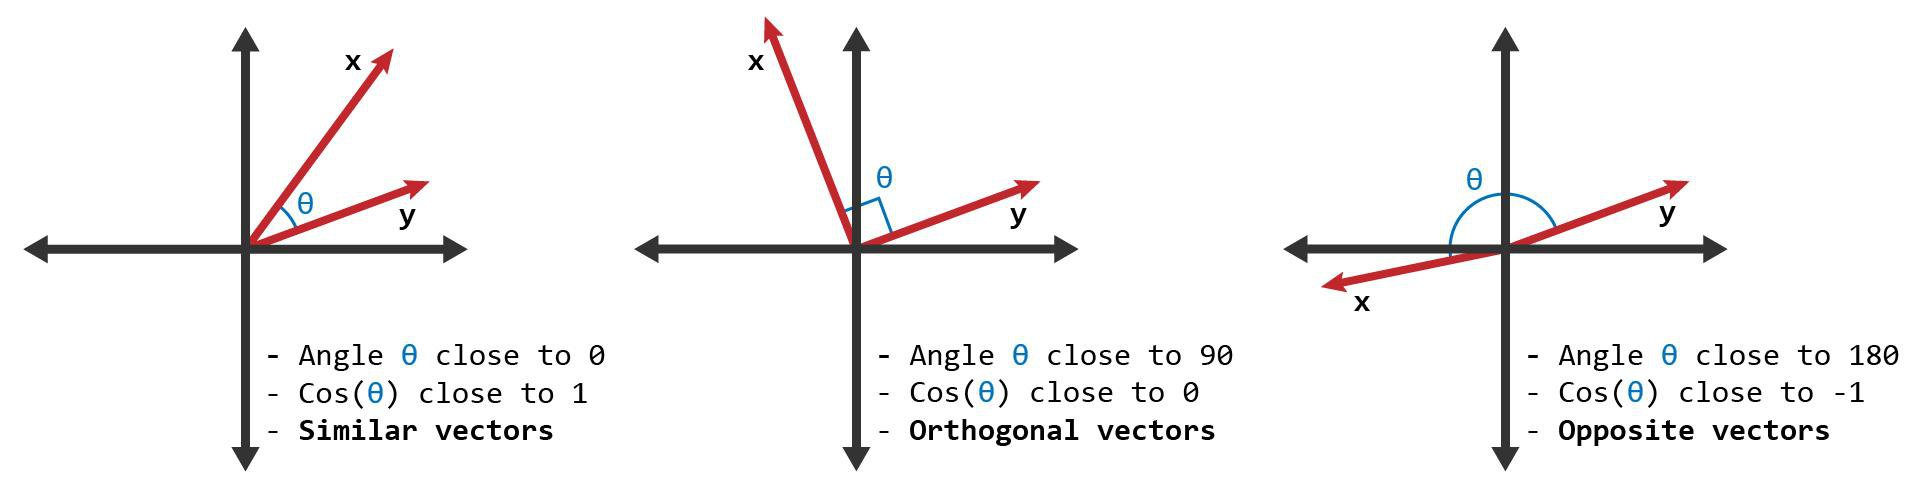

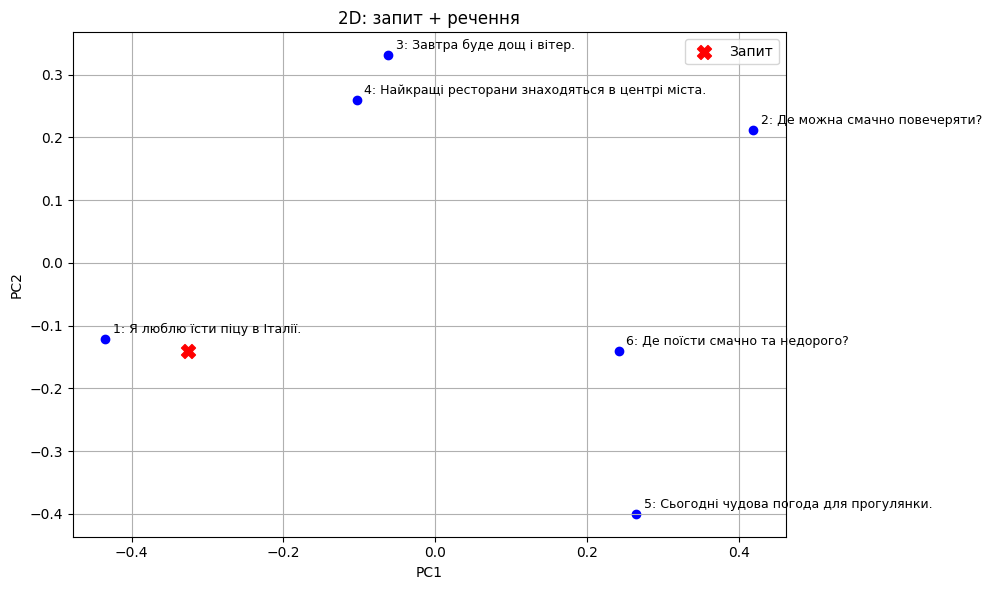

,Речення,Схожість із запитом
0,Я люблю їсти піцу в Італії.,0.872369
5,Де поїсти смачно та недорого?,0.741802
3,Найкращі ресторани знаходяться в центрі міста.,0.741000
2,Завтра буде дощ і вітер.,0.698389
4,Сьогодні чудова погода для прогулянки.,0.658982
1,Де можна смачно повечеряти?,0.596204


In [ ]:

# Показуємо top-3 схожі з оцінкою
top_k = 3
top_indices = similarities.argsort()[-top_k:][::-1]

retrieved = [(sentences[i], similarities[i]) for i in top_indices]

# Графік
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(np.vstack([query_embedding, embeddings]))

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[0, 0], embeddings_2d[0, 1], c='red', label='Запит', marker='X', s=100)
for i, (x, y) in enumerate(embeddings_2d[1:], start=1):
    plt.scatter(x, y, c='blue')
    plt.text(x + 0.01, y + 0.01, f"{i}: {sentences[i-1]}", fontsize=9)

plt.title("2D: запит + речення")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Табличка зі схожістю
df = pd.DataFrame({
    "Речення": sentences,
    "Схожість із запитом": similarities
}).sort_values(by="Схожість із запитом", ascending=False)

df

### Cosine VS Euclidean VS Dot-Product

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Вхідні речення та запит
sentences = [
    "Я люблю їсти піцу в Італії.",
    "Де можна смачно повечеряти?",
    "Завтра буде дощ і вітер.",
    "Найкращі ресторани знаходяться в центрі міста.",
    "Сьогодні чудова погода для прогулянки.",
    "Де поїсти смачно та недорого?"
]
query = "Де поїсти"

# Векторизація (без нормалізації для порівняння різних метрик)
sentence_embeddings = model.encode(sentences, normalize_embeddings=False)
query_embedding = model.encode([query], normalize_embeddings=False)

# Cosine Similarity
cos_sim = cosine_similarity(query_embedding, sentence_embeddings)[0]

# Euclidean Distance
euc_dist = euclidean_distances(query_embedding, sentence_embeddings)[0]

# Dot Product (пряме скалярне множення)
dot_product = np.dot(sentence_embeddings, query_embedding.T).flatten()

# Таблиця результатів
df = pd.DataFrame({
    "Речення": sentences,
    "Cosine Similarity": cos_sim,
    "Dot Product": dot_product,
    "Euclidean Distance": euc_dist
}).sort_values(by="Cosine Similarity", ascending=False)


df

,Речення,Cosine Similarity,Dot Product,Euclidean Distance
5,Де поїсти смачно та недорого?,0.779704,0.779704,0.663771
0,Я люблю їсти піцу в Італії.,0.749508,0.749508,0.707803
3,Найкращі ресторани знаходяться в центрі міста.,0.714908,0.714908,0.755105
2,Завтра буде дощ і вітер.,0.706483,0.706483,0.766182
1,Де можна смачно повечеряти?,0.696378,0.696378,0.779258
4,Сьогодні чудова погода для прогулянки.,0.659834,0.659834,0.824823


Dot product враховує довжину векторів, яка часто не несе змісту

Euclidean distance рахує “геометричну” відстань, яка не відображає змістовну близькість

Cosine similarity — найкраща метрика для змістовного порівняння, бо дивиться лише на напрямок думки, ігноруючи довжину речення чи обсяг.

## Простий RAG з Langchain

Показати RAG в іншому ноутбуці

# Advanced RAG штуки

### MMR(Maximal Marginal Relevance)

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Дані
texts = [
    "Ресторани в центрі Києва",
    "Сьогодні гарна погода в Києві.",
    "Ресторани в центрі Києва",
    "Футбол є найпопулярнішим видом спорту в Європі.",
    "У Львові багато кав’ярень з атмосферою.",
    "Доставка піци на Позняках"
]
docs = [Document(page_content=t) for t in texts]

# Embedding
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# FAISS база
vectorstore = FAISS.from_documents(docs, embeddings)

# Запит
query = "Де смачно поїсти в Києві?"
query_emb = embeddings.embed_query(query)

# MMR
retriever_mmr = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 3,           # кількість результатів, які повертаються
        "fetch_k": 10,    # кількість кандидатів для оцінки
        "lambda_mult": 0.5  # баланс релевантність/новизна (0.0 - тільки новизна, 1.0 - тільки релевантність)
    }
)
results_mmr = retriever_mmr.get_relevant_documents(query)

# Similarity
retriever_sim = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)
results_sim = retriever_sim.get_relevant_documents(query)

# Схожість вручну
doc_vectors = vectorstore.index.reconstruct_n(0, len(texts))
sims = cosine_similarity([query_emb], doc_vectors)[0]

# Вивід
print("\nTop-3 з Similarity:")
for doc in results_sim:
    print(f"- {doc.page_content}")

print("\nTop-3 з MMR:")
for doc in results_mmr:
    print(f"- {doc.page_content}")

print("\nКосинусна схожість (всі):")
for i, sim in enumerate(sims):
    print(f"{i+1}. {texts[i]} → {sim:.3f}")



Top-3 з Similarity:
- Сьогодні гарна погода в Києві.
- Ресторани в центрі Києва
- Ресторани в центрі Києва

Top-3 з MMR:
- Сьогодні гарна погода в Києві.
- Ресторани в центрі Києва
- Доставка піци на Позняках

Косинусна схожість (всі):
1. Ресторани в центрі Києва → 0.751
2. Сьогодні гарна погода в Києві. → 0.787
3. Ресторани в центрі Києва → 0.751
4. Футбол є найпопулярнішим видом спорту в Європі. → 0.673
5. У Львові багато кав’ярень з атмосферою. → 0.606
6. Доставка піци на Позняках → 0.658


| Без MMR (`similarity`)     | З MMR                         |
| -------------------------- | ----------------------------- |
| 3 chunks з одного місця    | покриття ширше                |
| LLM бачить повтори         | LLM бачить різні кути         |
| швидко, але менш стабільно | трохи повільніше, але точніше |


### Re-ranking

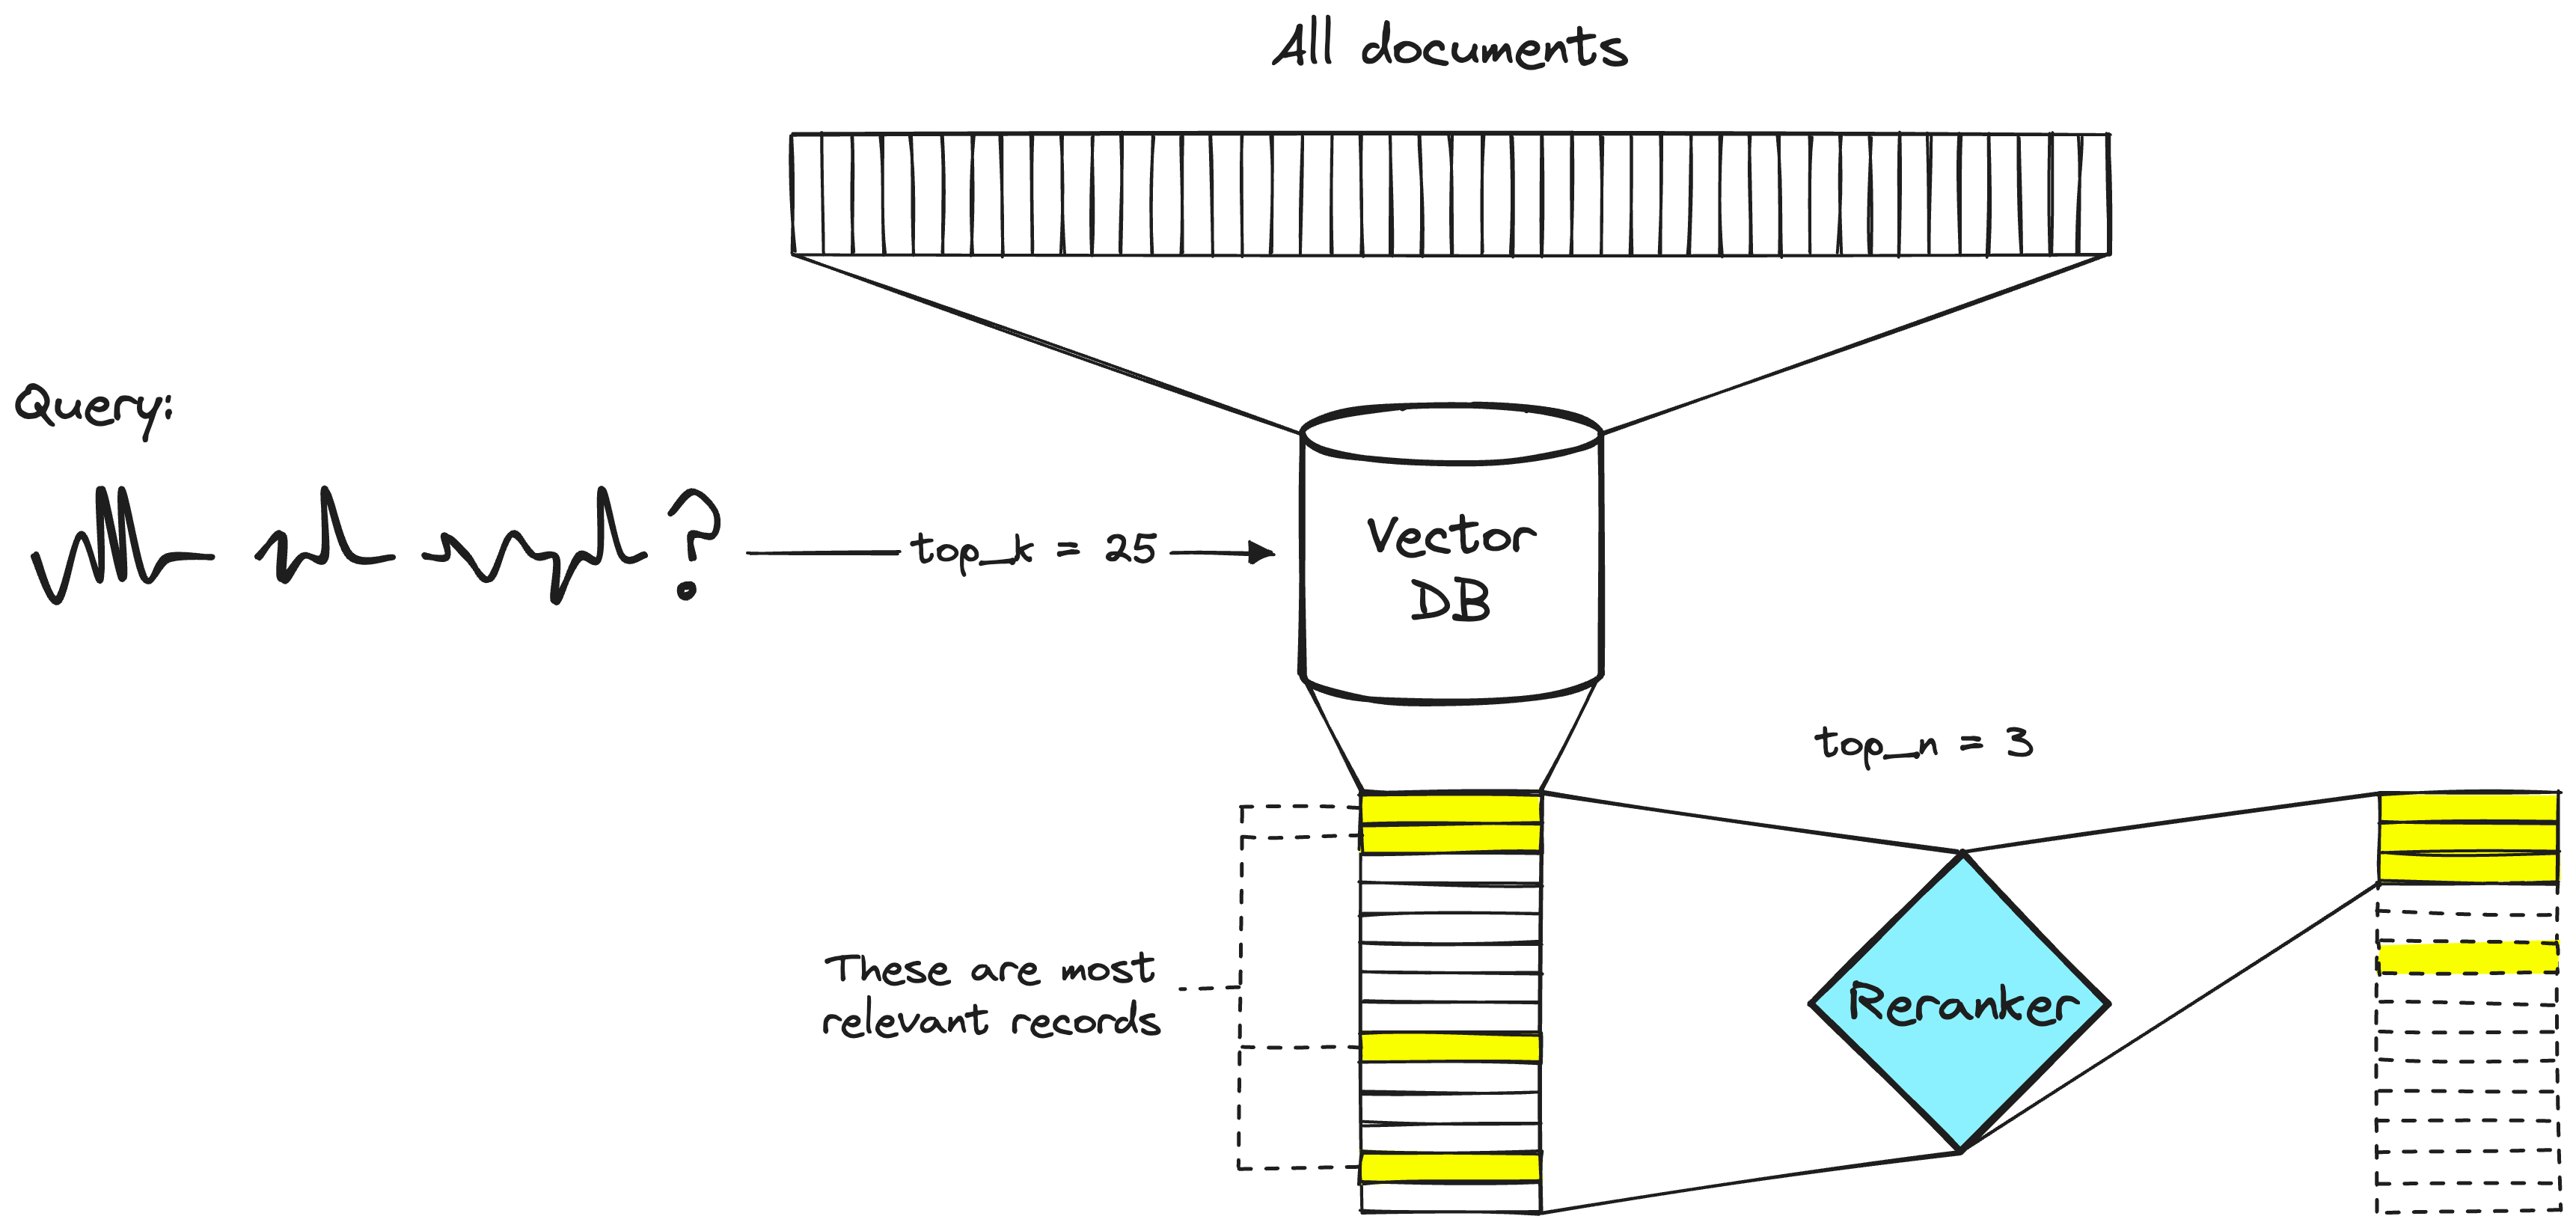


**Бфльше про reranker https://medium.com/@adnanmasood/re-ranking-mechanisms-in-retrieval-augmented-generation-pipelines-an-overview-8e24303ee789**

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

# Embeddings + FAISS
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(docs, embeddings)

# Reranker
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-v2-m3")
model = AutoModelForSequenceClassification.from_pretrained("BAAI/bge-reranker-v2-m3")

In [ ]:
query = "Де смачно поїсти в Києві?"

In [ ]:
#  Дані — невеликий датасет з текстовими документами
texts = [
    "Ресторани в центрі Києва",
    "Сьогодні гарна погода в Києві.",
    "Ресторани в центрі Києва",
    "Футбол є найпопулярнішим видом спорту в Європі.",
    "У Львові багато кав’ярень з атмосферою.",
    "Доставка піци на Позняках",
    "Де можна смачно повечеряти в Києві?",
    "Куди піти на вихідних у Львові",
    "Музеї та виставки у Харкові",
    "Кав’ярні з десертами у центрі Львова",
    "Найкращі ресторани азійської кухні в Києві",
    "Суші-бари поблизу Хрещатика",
    "Парки та відпочинок у Києві",
    "Погода у Львові на завтра",
    "Транспорт у Києві працює без перебоїв",
    "Заклади зі сніданками в Києві",
    "Де замовити доставку суші у Києві?",
    "Новини футболу: результати Ліги Чемпіонів",
    "Історичні пам’ятки в центрі Львова",
    "Київські ресторани з терасами та видом"
]
# Перетворення у формат Document
docs = [Document(page_content=t) for t in texts]

# Отримання ембедінгу для запиту (векторне представлення)
query_emb = embeddings.embed_query(query)

#  Переводимо модель в режим оцінювання (інференс)
model.eval()

# Функція для оцінювання релевантності кожного документу до запиту за допомогою reranker
def rerank(query, docs):
    # Формування пар (запит, документ)
    pairs = [(query, d.page_content) for d in docs]
    with torch.no_grad():  # без обчислення градієнтів
        inputs = tokenizer(
            [f"{q} [SEP] {d}" for q, d in pairs],  # формат: запит [SEP] документ
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        # Отримання логітів (оцінок релевантності)
        scores = model(**inputs).logits.squeeze().numpy()
    return scores

# Функція для виводу результатів (з можливим виводом rerank score)
def print_results(title, docs, scores=None):
    print(f"\n{title}")
    for i, doc in enumerate(docs):
        score_str = f" → rerank_score = {scores[i]:.4f}" if scores is not None else ""
        print(f"{i+1}. {doc.page_content}{score_str}")

# Просте векторне порівняння — cosine similarity
retriever_sim = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})
results_sim = retriever_sim.get_relevant_documents(query)
print_results("-- Similarity Only", results_sim)

# MMR — різноманітне повернення (уникає дублікатів), з лямбдою
retriever_mmr = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 10,          # фінальна кількість результатів
        "fetch_k": 20,    # скільки кандидатів витягнути спочатку
        "lambda_mult": 0.5  # баланс між релевантністю і новизною
    }
)
results_mmr = retriever_mmr.get_relevant_documents(query)
print_results("-- MMR Only", results_mmr)

# Reranker поверх результатів similarity
scores_sim_rerank = rerank(query, results_sim)
# Сортуємо по rerank score
sorted_sim = [doc for _, doc in sorted(zip(scores_sim_rerank, results_sim), key=lambda x: -x[0])]
sorted_scores_sim = sorted(scores_sim_rerank, reverse=True)
print_results("-- Reranker on Similarity", sorted_sim, sorted_scores_sim)

# Reranker поверх результатів з MMR
scores_mmr_rerank = rerank(query, results_mmr)
sorted_mmr = [doc for _, doc in sorted(zip(scores_mmr_rerank, results_mmr), key=lambda x: -x[0])]
sorted_scores_mmr = sorted(scores_mmr_rerank, reverse=True)
print_results("-- Reranker on MMR", sorted_mmr, sorted_scores_mmr)



-- Similarity Only
1. Де можна смачно повечеряти в Києві?
2. Парки та відпочинок у Києві
3. Де замовити доставку суші у Києві?
4. Сьогодні гарна погода в Києві.
5. Куди піти на вихідних у Львові
6. Найкращі ресторани азійської кухні в Києві
7. Транспорт у Києві працює без перебоїв
8. Історичні пам’ятки в центрі Львова
9. Кав’ярні з десертами у центрі Львова
10. Ресторани в центрі Києва

-- MMR Only
1. Де можна смачно повечеряти в Києві?
2. Куди піти на вихідних у Львові
3. Транспорт у Києві працює без перебоїв
4. Сьогодні гарна погода в Києві.
5. Найкращі ресторани азійської кухні в Києві
6. Де замовити доставку суші у Києві?
7. Доставка піци на Позняках
8. Історичні пам’ятки в центрі Львова
9. Парки та відпочинок у Києві
10. Футбол є найпопулярнішим видом спорту в Європі.

-- Reranker on Similarity
1. Де можна смачно повечеряти в Києві? → rerank_score = 2.3839
2. Ресторани в центрі Києва → rerank_score = -3.9545
3. Найкращі ресторани азійської кухні в Києві → rerank_score = -7.4547
4

###  Hybrid Retrieval (BM25 + Embeddings)

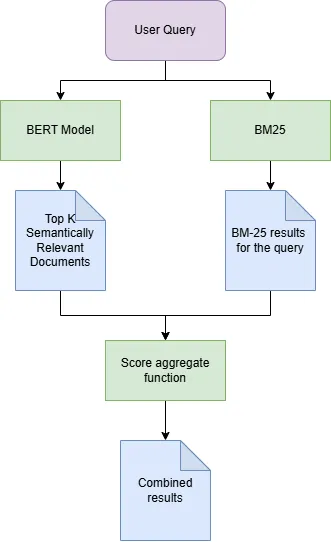


**BM25 explained + Why better than TF-IDF https://medium.com/@kushagramisra10/unlocking-the-power-of-bm25-why-its-outshining-tf-idf-in-the-world-of-search-152413392790**

**А чого?**

BM25 добре знаходить точні збіги (імена, назви, коди).

Embeddings краще ловлять семантичну суть ("місце поїсти" = "ресторани").

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.schema import Document
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

#  Вхідні дані
texts = [
    "Щоб встановити Python, завантажте інсталятор з офіційного сайту.",
    "Docker дозволяє ізолювати середовища розробки.",
    "REST API — це архітектурний стиль для створення веб-сервісів.",
    "Git використовується для контролю версій у розробці програмного забезпечення.",
    "Щоб створити віртуальне середовище в Python, використовуйте команду `python -m venv env`.",
    "Щоб запустити контейнер Docker, використовуйте `docker run` з відповідними параметрами.",
    "У Flask маршрути визначаються за допомогою декораторів `@app.route()`.",
    "SQL — мова для взаємодії з реляційними базами даних.",
    "JavaScript виконується в браузері та дозволяє створювати інтерактивні інтерфейси.",
    "API ключі використовуються для автентифікації запитів до зовнішніх сервісів.",
    "Щоб оновити пакети у pip, використовуйте `pip install --upgrade`.",
    "JSON — це формат обміну даними, зручний для API.",
    "Кешування відповіді API зменшує навантаження на сервер.",
    "CI/CD забезпечує автоматизацію збірки, тестування та деплою.",
    "GitHub Actions дозволяє створювати CI-пайплайни без зовнішніх інструментів.",
    "Щоб створити репозиторій на GitHub, натисніть кнопку 'New Repository'.",
    "Dockerfile описує інструкції для побудови образу Docker.",
    "WebSocket дозволяє встановити постійне з'єднання між клієнтом і сервером.",
    "npm використовується для керування пакетами в екосистемі Node.js.",
    "Markdown дозволяє форматувати текст у README-файлах на GitHub."
]

#  Запит
query = "Як запустити Python проєкт у віртуальному середовищі?"

# Створюємо документи
documents = [Document(page_content=text) for text in texts]

# HuggingFace Embeddings + FAISS
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(documents, embeddings)
vector_retriever = vector_store.as_retriever(search_kwargs={"k": 6})

#BM25
bm25_retriever = BM25Retriever.from_documents(documents)
bm25_retriever.k = 6

# Гібридний EnsembleRetriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, vector_retriever],
    weights=[0.3, 0.7]
)

# Отримуємо результати з кожного ретрівера
bm25_results = bm25_retriever.get_relevant_documents(query)
vector_results = vector_retriever.get_relevant_documents(query)
ensemble_results = ensemble_retriever.get_relevant_documents(query)

# Вивід результатів
def print_results(title, results):
    print(f"\n {title}")
    for idx, doc in enumerate(results, start=1):
        print(f"{idx}. {doc.page_content}")

# Виводимо
print_results("FAISS (embedding-пошук)", vector_results)
print_results("BM25 (ключові слова)", bm25_results)
print_results("Ensemble (гібридний підхід)", ensemble_results)



 FAISS (embedding-пошук)
1. Щоб встановити Python, завантажте інсталятор з офіційного сайту.
2. Щоб створити віртуальне середовище в Python, використовуйте команду `python -m venv env`.
3. Кешування відповіді API зменшує навантаження на сервер.
4. CI/CD забезпечує автоматизацію збірки, тестування та деплою.
5. API ключі використовуються для автентифікації запитів до зовнішніх сервісів.
6. JSON — це формат обміну даними, зручний для API.

 BM25 (ключові слова)
1. Щоб запустити контейнер Docker, використовуйте `docker run` з відповідними параметрами.
2. Markdown дозволяє форматувати текст у README-файлах на GitHub.
3. Щоб оновити пакети у pip, використовуйте `pip install --upgrade`.
4. Git використовується для контролю версій у розробці програмного забезпечення.
5. Dockerfile описує інструкції для побудови образу Docker.
6. WebSocket дозволяє встановити постійне з'єднання між клієнтом і сервером.

 Ensemble (гібридний підхід)
1. Щоб встановити Python, завантажте інсталятор з офіційного 

| Метод        | Плюси                                 | Мінуси                                 |
| ------------ | ------------------------------------- | -------------------------------------- |
| **FAISS**    | Семантичне розуміння                  | Може проґавити точні інструкції        |
| **BM25**     | Добре для точного збігу ключових слів | Ігнорує сенс, легко галюцинує          |
| **Ensemble** | Баланс між точністю і змістом         | Потрібне налаштування ваг (гранулярне) |


### RAG evaluation

1. Оцінка Retrieval частини
2. Оцінка Generation частини  

In [ ]:
# pip install sacrebleu rouge-score sentence-transformers

from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util

# ініціалізація sentence transformer
embed_model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:


dataset = [
    # --- GOOD CASE ---
    {
        "question": "What is photosynthesis?",
        "contexts": [
            "Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.",
            "It occurs in chloroplasts and produces oxygen."
        ],
        "ground_truth_answer": "Photosynthesis is the process where plants convert CO₂ and water into glucose and oxygen using sunlight.",
        "predicted_answer": "Plants convert carbon dioxide and water into glucose using sunlight, releasing oxygen.",
        "retrieved_contexts": [
            "Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.",
            "It occurs in chloroplasts and produces oxygen."
        ]
    },
    # --- BAD RETRIEVER CASE ---
    {
        "question": "Why is the sky blue?",
        "contexts": [
            "The sky appears blue because molecules in the air scatter blue light more than red light.",
            "This is known as Rayleigh scattering."
        ],
        "ground_truth_answer": "The sky is blue due to Rayleigh scattering, which scatters shorter (blue) wavelengths more efficiently.",
        "predicted_answer": "Rayleigh scattering makes the sky blue by scattering blue wavelengths more than red.",
        "retrieved_contexts": [
            "Water boils at 100 degrees Celsius.",
            "Mount Everest is the highest mountain on Earth."
        ]
    },
    # --- HALLUCINATION CASE ---
    {
        "question": "How do vaccines work?",
        "contexts": [
            "Vaccines stimulate the immune system by presenting antigens from pathogens.",
            "These antigens are typically inactivated or weakened forms so they don't cause disease."
        ],
        "ground_truth_answer": "Vaccines work by exposing the immune system to harmless antigens, training it to recognize and fight the real pathogen in future.",
        "predicted_answer": "Vaccines alter human DNA to create immunity, allowing the body to permanently resist infections.",
        "retrieved_contexts": [
            "Vaccines stimulate the immune system by presenting antigens from pathogens.",
            "These antigens are typically inactivated or weakened forms so they don't cause disease."
        ]
    }
]

In [ ]:
def compute_metrics(question, pred, truth, retrieved_contexts, gt_contexts):
    # -------------------------------
    # МЕТРИКИ ДЛЯ ЯКОСТІ ВІДПОВІДІ
    # -------------------------------

    # BLEU — показує схожість з еталонною відповіддю по н-грамам
    # (добре, коли відповіді текстово подібні)
    bleu = corpus_bleu([pred], [[truth]]).score / 100

    # ROUGE-L — схожість за довжиною найдовшої спільної підпослідовності слів
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_l = rouge.score(truth, pred)['rougeL'].fmeasure

    # -------------------------------
    # ТОЧНІ МЕТРИКИ ДЛЯ РЕТРІВАЛУ
    # -------------------------------

    # ctx_precision — скільки з витягнутого релевантне
    # ctx_recall — скільки з потрібного ми справді витягнули
    retrieved = set(retrieved_contexts)
    gt = set(gt_contexts)
    tp = len(retrieved & gt)  # точний збіг між retrieved та ground truth
    precision = tp / len(retrieved) if retrieved else 0
    recall = tp / len(gt) if gt else 0

    # -------------------------------
    # СЕМАНТИЧНА ТОЧНІСТЬ РЕТРІВАЛУ
    # -------------------------------

    # semantic_ctx_precision — для кожного retrieved контексту шукаємо
    # найбільш схожий ground truth (за cosine similarity), потім усереднюємо
    sim_precision_scores = []
    for r in retrieved_contexts:
        r_vec = embed_model.encode(r)
        max_sim = 0
        for g in gt_contexts:
            g_vec = embed_model.encode(g)
            sim = float(util.cos_sim(r_vec, g_vec))
            max_sim = max(max_sim, sim)
        sim_precision_scores.append(max_sim)
    semantic_ctx_precision = sum(sim_precision_scores) / len(sim_precision_scores) if sim_precision_scores else 0

    # semantic_ctx_recall — аналогічно, але зворотно:
    # для кожного ground truth контексту шукаємо найбільш схожий з retrieved
    sim_recall_scores = []
    for g in gt_contexts:
        g_vec = embed_model.encode(g)
        max_sim = 0
        for r in retrieved_contexts:
            r_vec = embed_model.encode(r)
            sim = float(util.cos_sim(r_vec, g_vec))
            max_sim = max(max_sim, sim)
        sim_recall_scores.append(max_sim)
    semantic_ctx_recall = sum(sim_recall_scores) / len(sim_recall_scores) if sim_recall_scores else 0

    # -------------------------------
    # ВІДПОВІДНІСТЬ ВІДПОВІДІ ПИТАННЮ
    # -------------------------------

    # answer_relevancy — наскільки відповідь семантично схожа на запитання
    # (не обов’язково дослівно, головне — сенс)
    q_emb = embed_model.encode(question, convert_to_tensor=True)
    a_emb = embed_model.encode(pred, convert_to_tensor=True)
    answer_relevancy = float(util.cos_sim(q_emb, a_emb))

    # -------------------------------
    # ЧИ НЕ ВИГАДАЛА МОДЕЛЬ
    # -------------------------------

    # faithfulness — простий хардкод: якщо є певні слова, вважаємо що галюцинація
    # (в реальному житті це робиться через LLM або RAGAS)
    hallucinated_keywords = ["alter human dna", "permanently resist"]
    faithfulness = 0.0 if any(k in pred.lower() for k in hallucinated_keywords) else 1.0

    # Повертаємо усі метрики в словнику
    return {
        "bleu": round(bleu, 3),
        "rouge_l": round(rouge_l, 3),
        "ctx_precision": round(precision, 3),
        "ctx_recall": round(recall, 3),
        "semantic_ctx_precision": round(semantic_ctx_precision, 3),
        "semantic_ctx_recall": round(semantic_ctx_recall, 3),
        "faithfulness": faithfulness,
        "answer_relevancy": round(answer_relevancy, 3)
    }



# evaluate
results = []
for item in dataset:
    metrics = compute_metrics(
        item["question"],
        item["predicted_answer"],
        item["ground_truth_answer"],
        item["retrieved_contexts"],
        item["contexts"]
    )
    print(f"Q: {item['question']}")
    print(f"Answer: {item['predicted_answer']}")
    print(f"Retrieved: {item['retrieved_contexts']}")
    print(f"Metrics: {metrics}\n")
    results.append(metrics)

# average
avg = {k: round(sum(m[k] for m in results)/len(results), 3) for k in results[0]}
print("Average metrics:", avg)


Q: What is photosynthesis?
Answer: Plants convert carbon dioxide and water into glucose using sunlight, releasing oxygen.
Retrieved: ['Photosynthesis is the process by which green plants use sunlight to synthesize nutrients from carbon dioxide and water.', 'It occurs in chloroplasts and produces oxygen.']
Metrics: {'bleu': 0.189, 'rouge_l': 0.571, 'ctx_precision': 1.0, 'ctx_recall': 1.0, 'semantic_ctx_precision': 1.0, 'semantic_ctx_recall': 1.0, 'faithfulness': 1.0, 'answer_relevancy': 0.641}

Q: Why is the sky blue?
Answer: Rayleigh scattering makes the sky blue by scattering blue wavelengths more than red.
Retrieved: ['Water boils at 100 degrees Celsius.', 'Mount Everest is the highest mountain on Earth.']
Metrics: {'bleu': 0.067, 'rouge_l': 0.5, 'ctx_precision': 0.0, 'ctx_recall': 0.0, 'semantic_ctx_precision': 0.088, 'semantic_ctx_recall': 0.088, 'faithfulness': 1.0, 'answer_relevancy': 0.726}

Q: How do vaccines work?
Answer: Vaccines alter human DNA to create immunity, allowing t

| Метрика                  | коли 1                                                  | Коли 0                                                        | Що тюнити                                                                 |
|--------------------------|----------------------------------------------------------|----------------------------------------------------------------|---------------------------------------------------------------------------|
| `ctx_precision`          | Більшість витягнутих контекстів — правильні              | Ретрівер витягнув нерелевантне                                 | Ретрівер (алгоритм, embedding-модель, фільтри, chunking)                 |
| `ctx_recall`             | Знайшли всі важливі контексти                            | Пропущено частину потрібного контексту                         | Ретрівер (`top_k`, hybrid search, збільшення покриття бази)             |
| `semantic_ctx_precision` | Витягнуті контексти семантично схожі на ground truth     | Витягнуті фрагменти зовсім не передають потрібну суть          | Ретрівер + embedding модель + семантична обробка запиту                 |
| `semantic_ctx_recall`    | Кожен ground truth має схожий фрагмент серед витягнутого | Жоден ground truth контекст не був знайдений навіть приблизно  | Ретрівер, покриття бази, подібність embeddings, chunk overlap           |
| `faithfulness`           | У відповіді немає вигадок                                | Галюцинації, тобто відповіді не в контексті                    | Промпт для LLM, перевірка фактів, RAGAS, LLM alignment                  |
| `answer_relevancy`       | Відповідь семантично відповідає питанню                  | Відповідь не зовсім про те, що спитали                         | Промпт, інструкції до LLM, few-shot приклади                            |
| `BLEU`, `ROUGE-L`        | Відповідь схожа на ground truth (текстово)               | Відповідь дуже інша (може бути синонім або галюцинація)        | Якщо інші метрики ок — не тюнити; інакше — перевірити стиль/структуру   |


#### Advanced RAG algs

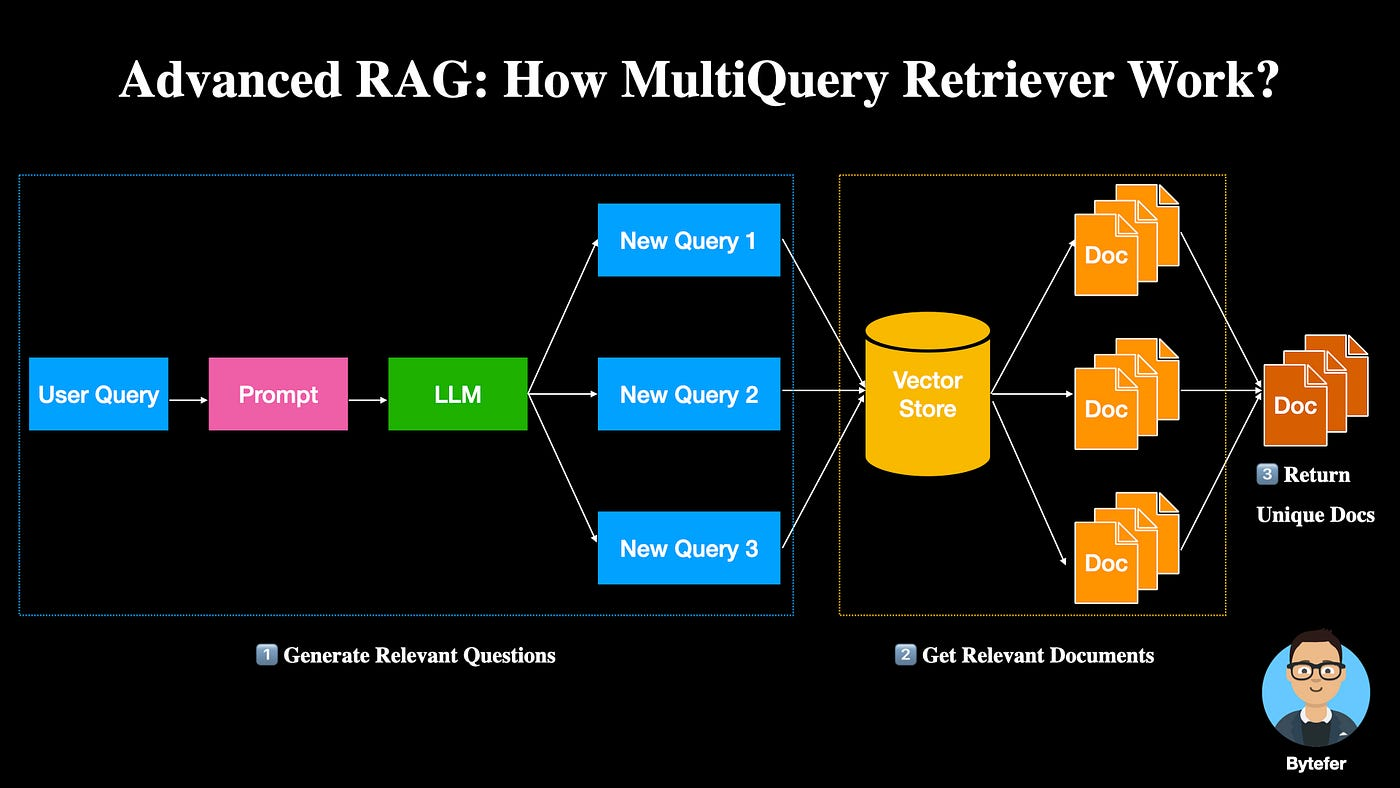

# BERT використання

## PII detection

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Готова модель для NER
model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# NER pipeline
ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Текст з PII
text = "My name is Alice and I live in Paris. My email is alice@example.com. My insurance numder"

# Детекція
results = ner(text)

# Вивід
for r in results:
    print(f"{r['entity_group']} → {r['word']} ({r['score']:.2f})")

Device set to use cuda:0


PER → Alice (0.98)
LOC → Paris (1.00)


## BERT embeddings + cosine similiraty

**Реальні юзкейси**

Stack Overflow / Stack Exchange — для пошуку схожих питань

Zendesk / підтримка клієнтів — щоб швидко знаходити схожі тікети

E-commerce — класифікація і злиття дублікатних описів товарів

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

q1 = "How can I lose weight fast?"
q2 = "What is the best way to reduce body fat quickly?"

emb1 = model.encode(q1, convert_to_tensor=True)
emb2 = model.encode(q2, convert_to_tensor=True)

cos_sim = util.pytorch_cos_sim(emb1, emb2)
print(f"Cosine similarity: {cos_sim.item():.4f}")
# якщо  cos_sim більше встановленого порогу(визначається розробником), то речення вважаються подібними і вискакують в рекомендаціях

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Cosine similarity: 0.7348


# Fine-Tuning

1. Підготовка даних

– Збір релевантних текстів/діалогів

– Форматування

– Токенізація

2. Вибір моделі

– Наприклад: LLaMA, Mistral, Gemma, GPT-J

– З урахуванням розміру та ресурсу

3. Налаштування fine-tuning

– Метод: повний, LoRA, QLoRA

– Вибір фреймворку (Hugging Face Transformers, PEFT, Axolotl)

– Гіперпараметри: lr, batch_size, epochs

4. Навчання

– Запуск тренування

– Логування (W&B, TensorBoard)

5. Оцінка

– Метрики: Perplexity, BLEU, ROUGE

– Ручна або автоматизована перевірка



## Підготовка даних

1. Визначити задачу

| Тип задачі        | Опис прикладу                     | Формат prompt/completion                               |
| ----------------- | --------------------------------- | ------------------------------------------------------ |
| Класифікація      | Визначити тональність тексту      | `Prompt: Text ➝ Completion: Positive/Negative`         |
| Генерація         | Продовжити текст, написати статтю | `Prompt: Початок тексту ➝ Completion: Продовження`     |
| Питання-відповідь | Відповісти на питання             | `Prompt: Питання ➝ Completion: Відповідь`              |
| Інструкції        | Виконати завдання по інструкції   | `Prompt: "Напиши листа..." ➝ Completion: Готовий лист` |


2. Підготовка даних(Форматування)

Спочатку можна визначитися з фінальним промптом(Разом з System Prompt)

Це може бути:

        One-shot / Few-shot prompt (є приклади)

        JSON-style input/utput

        # Заголовки / markdown-структура

        Просто інструкція (Напиши твір на тему...)

**Визначаєте структуру запиту й очікуваної відповіді.**



3. Форматуєте датасет у такому ж стилі

**СТРУКТУРА ДАНИХ МАЄ БУТИ ОДНАКОВА ДЛЯ ВСІХ ТРЕЙН СЕМПЛІВ**

### System Prompt під час тренування

Ви готуєте тренувальні приклади в точно такому ж вигляді, як той промпт, що  придумали вище.

    {"prompt": system_prompt + user_input, "completion": ...}
або **ChatML формат**(OpenAI стайл)

    {
      "messages": [
        {"role": "system", "content": "Ти експерт з ML"},
        {"role": "user", "content": "Що таке gradient descent?"},
        {"role": "assistant", "content": "Це метод оновлення ваг у моделі..."}
      ]
    }

*Цей формат чудовий для LoRA/instruction tuning з chat-моделями (LLaMA, Mistral) ;)*


### Альтернатива: не вчити з system-prompt

Це має сенс :

    1.якщо ви будете вставляти system prompt лише під час інференсу

    2.і ви тренуєте на загальному стилі (нейтрально: “просто відповідай на питання”)

У такому випадку system prompt обробляється тільки інференсом, а модель вчиться лиш на парі “запит–відповідь”.

### JSONL(JSON Lines)  формат
JSSONL = один JSON-об’єкт на рядок у текстовому файлі

## LoRA / PEFT

LoRA (Low-Rank Adaptation) — це метод, який дозволяє не змінювати всі ваги LLM, а лише невеликі адаптивні шари.

- Fine-tune для обмеженої задачі (одна інструкція, стиль, домен)
- Немає багато GPU / RAM (наприклад, Google Colab)
- Модель буде оновлюватись часто або на різні варіанти

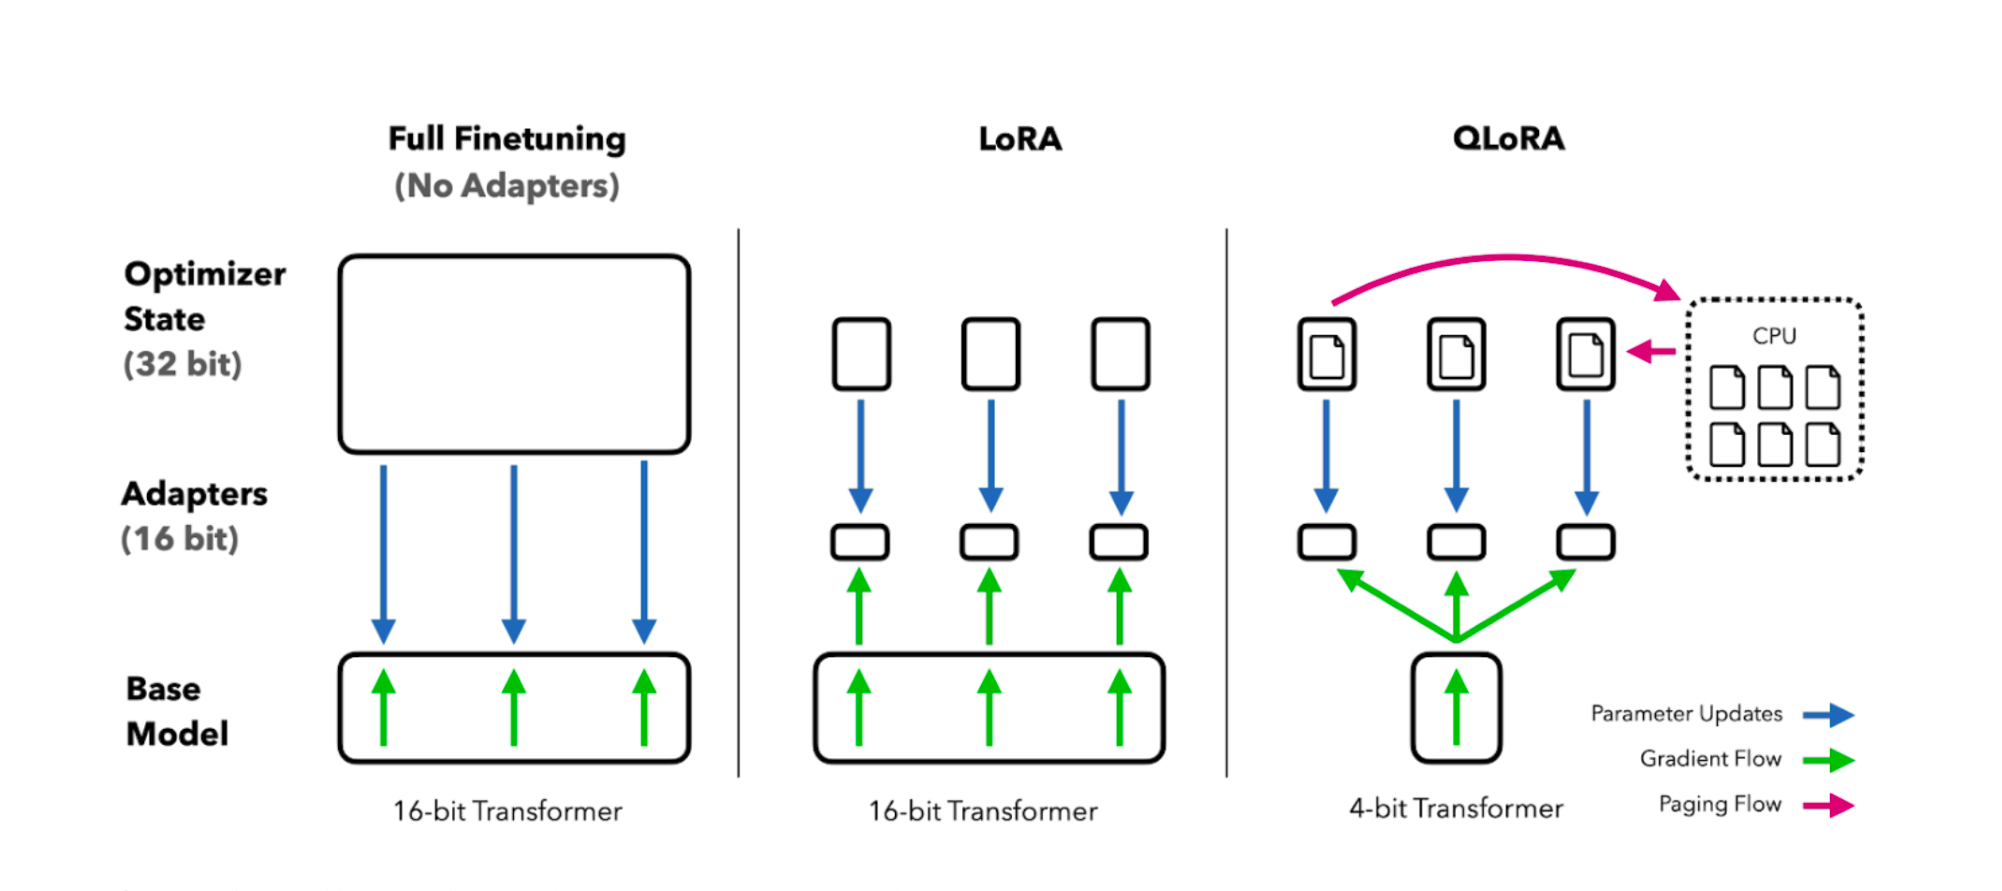

**Приклад тюнінгу з LoRA https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms**

**Якась LoRA документація https://huggingface.co/docs/peft/package_reference/lora**

In [ ]:
# ======ПРИКЛАД КОДУ НЕ РАНИТИ =====

from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("your-base-model", device_map = 'cuda')

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

| Параметр         | Пояснення                                   |
| ---------------- | ------------------------------------------- |
| `r`              | Розмір low-rank матриць (4–16)              |
| `lora_alpha`     | Масштаб адаптерів                           |
| `lora_dropout`   | Регуляризація LoRA                          |
| `target_modules` | Куди вставити LoRA (`q_proj`, `v_proj`)     |
| `bias`           | Чи тренувати зміщення                       |
| `task_type`      | Тип задачі (`CAUSAL_LM`, `SEQ_2_SEQ_LM`...) |


target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj', 'lm_head']



In [ ]:
# ======ПРИКЛАД КОДУ НЕ РАНИТИ =====

model_name = checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir="outputs",
    learning_rate=5e-4,
    num_train_epochs=50,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    # можна додати фолбек earlystopping
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

### Оцінка

**Номер 1 - вручну**, але
Класичні метрики (коли є "правильна відповідь")

**Для класифікації**

    Accuracy — % правильних відповідей

    F1-score — баланс precision/recall

**Для текстової генерації**

    BLEU — схожість n-грам (часто в перекладі)

    ROUGE — наскільки відповідь “покриває” референс

    BERTScore — порівняння через embeddings, гнучкіше до формулювань

**LLM-as-a-Judge / GPT-4 Eval**

    prompt = f"""Оцініть наступну відповідь:
    Питання: {question}
    Відповідь: {generated_answer}
    Оцініть за шкалою від 1 до 5, де 5 — ідеально технічно і точно."""

**Custom eval (rule-based)**

    ключове слово у відповіді

    Чи відповідає JSON-структурі



### Wandb

In [ ]:
import wandb

# 1. Ініціалізація wandb
wandb.init(project="lora-finetune", name="mistral-small-lora")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nika- to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Фінальний пайплайн коротко
1. Придумуємо структуру prompt
2. Готуємо датасет у JSONL
3. Налаштовуємо LoRA
4. Запускаємо тренування
5. Оцінюємо результати
# New Section

# AI Agents

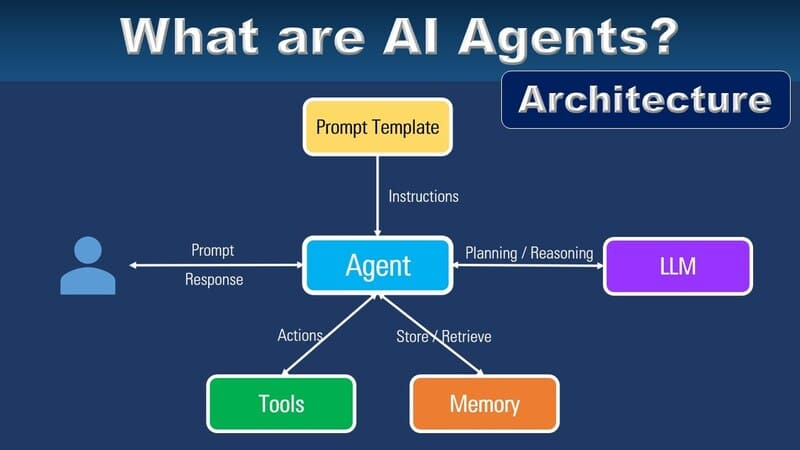